Purpose of this notebook is to create a Bias Voltage vs energy plot of the quasiparticle scattering point in Jake's STM data of graphene.

Method
-Load in the files in ASCII format to preserve momentum vs pixel information
- Use OpenCV to filter, increase contrast, and do blob detection
- Fit gaussian to center of blobs (or max values)
  - Standard deviations of the gaussian fit are the x and y values


TODO:
Make Images all Same Size

### Imports

In [2]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt

import cv2

### Loading in Files

In [3]:
# Add Units Later
df = pd.read_table(r"XYZData/195XYZ.txt", skiprows=3, sep='\t', header=None, names=['X', 'Y', 'Z'])

In [4]:
df.head()

,X,Y,Z
0,0.000000,0.0,1.741010e-06
1,0.066928,0.0,9.574110e-07
2,0.133856,0.0,2.064150e-06
3,0.200785,0.0,9.339860e-07
4,0.267713,0.0,1.818780e-06


Text(0, 0.5, 'y (1/nm)')

Error in callback <function _draw_all_if_interactive at 0x0000029CCF682CA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

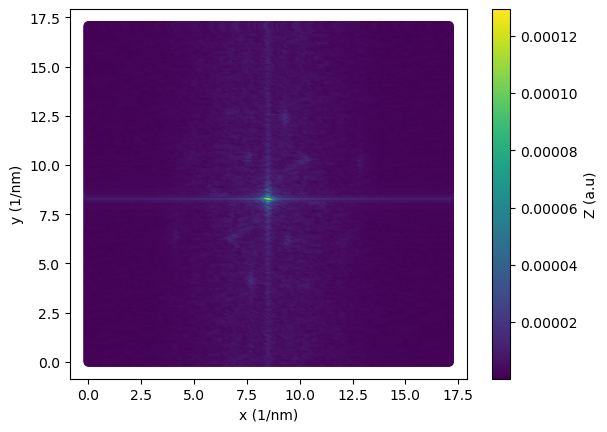

In [5]:
# Now lets see what this looks like
fig1, ax1 = plt.subplots()

sc1 = ax1.scatter(df['X'], df['Y'], c=df['Z'])
cb1 = plt.colorbar(sc1, ax=ax1)
cb1.set_label('Z (a.u)')
ax1.set_xlabel("x (1/nm)")
ax1.set_ylabel("y (1/nm)")

### Normalizing Data to OpenCV Image

In [ ]:
from scipy.interpolate import griddata

In [ ]:
# (Z - np.min(Z)) / (np.max(Z) - np.min(Z)) * 255

imgsize = (1000, 1000)
gx, gy = np.meshgrid(np.linspace(df['X'].min(), df['X'].max(), imgsize[0]),
                     np.linspace(df['Y'].min(), df['Y'].max(), imgsize[1]),)

# Interpolate into a grid
gz = griddata((df['X'], df['Y']), df['Z'], (gx, gy), method='linear')

# Normalize between 0 and 255
gzn = (gz - np.nanmin(gz)) / (np.nanmax(gz) - np.nanmin(gz)) * 255
gzn = np.nan_to_num(gzn, nan=0).astype(np.uint8)

In [ ]:
dpx = gx[0]

### Image Processing

In [ ]:
cp = gzn.copy()

# Blob Detection Parameters
params = cv2.SimpleBlobDetector_Params()
params.filterByColor = False
params.blobColor = 0

params.filterByArea = True
params.minArea = 100 # Highly depending on image resolution and dice size
params.maxArea = 2000.

params.filterByCircularity = False
params.minCircularity = 0.1 # 0.7 could be rectangular, too. 1 is round. Not set because the dots are not always round when they are damaged, for example.
params.maxCircularity = 10 # infinity.

params.filterByConvexity = False

params.filterByInertia = True
params.minInertiaRatio = 0.15 # 1 is round, 0 is anywhat
params.maxInertiaRatio = 1

params.minThreshold = 20
params.maxThreshold = 200
params.thresholdStep = 5
params.minDistBetweenBlobs = 50
params.minRepeatability = 2

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(cp)


im_with_keypoints = cv2.drawKeypoints(cp, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


In [ ]:
print(f"# x y r")
for i, k in enumerate(keypoints):
  x, y, r = k.pt[0], k.pt[1], k.size
  #x = x - 500
  #y = -1 * (y - 500)
  print(f"{i:d} {x:.2f} {y:.2f}, {r:.2f}")

# x y r
0 547.30 739.92, 30.72
1 447.87 625.87, 20.50
2 596.06 608.26, 27.82
3 406.98 386.82, 27.68
4 554.78 369.28, 19.41
5 455.22 255.32, 31.62
6 501.57 497.67, 25.69


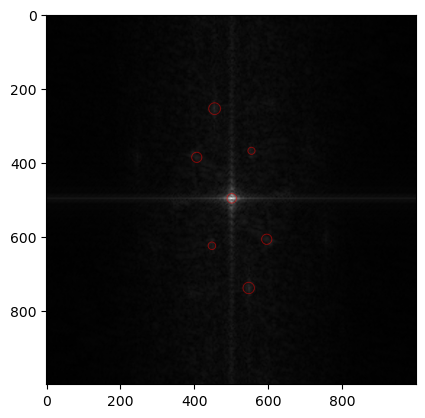

In [ ]:
plt.imshow(im_with_keypoints)

In [ ]:
# Process the image and detect the scattering points
# Can try contrast later
def getBlobs(img):
  return 0

### Get data around blob to fit

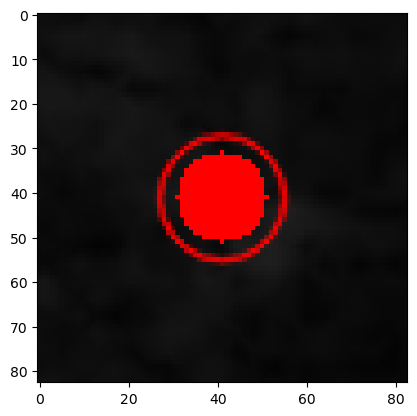

In [ ]:
# Test with a blob
#2 596.06 608.26, 27.82
x, y, r = 596.06, 608.26, 27.82 #pixels

# 596.06 608.26

imgsize = 1000
hsize = imgsize/2

cv2.circle(im_with_keypoints, (int(x), int(y)), 1, (255, 0, 0), -1)

# Undo centering
#x = int(x + hsize)
#y = int(hsize - y)

# Want square of values a bit larger than diameter of blob
# It seems like r is the diameter so our window is two times the diameter
sw = int(1.5 * 2 * r)

zoomed_width = sw
zoomed_height = sw

zoomed_x = int(x - zoomed_width // 2)
zoomed_y = int(y - zoomed_height // 2)

zoom = im_with_keypoints[zoomed_y:zoomed_y+zoomed_height, zoomed_x:zoomed_x+zoomed_width]

plt.imshow(zoom)

In [ ]:
sw

83

In [ ]:
zoomed_x

555

In [ ]:
# This maps from the pixel space to the interpolated frequency space
frqx1, frqx2 = gx[0][int(zoomed_x - sw/2)], gx[0][int(zoomed_x + sw/2)]
frqy2, frqy1 = gy[:,0][::-1][int(zoomed_y)], gy[:,0][::-1][int(zoomed_y + sw + sw/2)]

print(f"x = [{frqx1:.2f} {frqx2:.2f}] y = [{frqy1:.2f} {frqy2:.2f}]")

# Get subset of XYZ data
df_sub = df[(df['X'] >= frqx1) & (df['X'] <= frqx2) & (df['Y'] >= frqy1) & (df['Y'] <= frqy2)]
#df_sub = df[(df['X'] <= 10) & (df['Y'] <= int(frqy2))]
#df_sub = df_sub[(df_sub['X'] >= 5) & (df_sub['Y'] >= int(frqy1))]

df_sub.head()

x = [8.76 10.18] y = [5.26 7.38]


,X,Y,Z
20355,8.767599,5.287331,0.000008
20356,8.834527,5.287331,0.000005
20357,8.901455,5.287331,0.000005
20358,8.968384,5.287331,0.000006
20359,9.035312,5.287331,0.000007


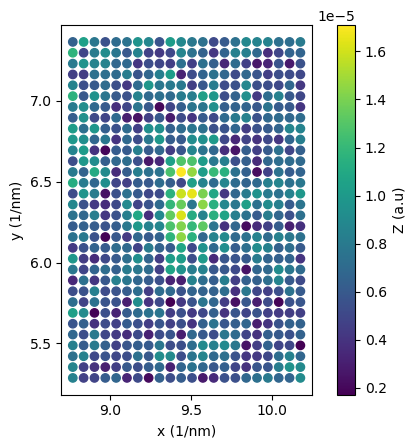

In [ ]:
# Now lets see what this looks like
fig2, ax2 = plt.subplots()

sc2 = ax2.scatter(df_sub['X'], df_sub['Y'], c=df_sub['Z'])
cb2 = plt.colorbar(sc2, ax=ax2)
cb2.set_label('Z (a.u)')
ax2.set_xlabel("x (1/nm)")
ax2.set_ylabel("y (1/nm)")
ax2.set_aspect('equal')
#ax2.set_xlim([frqx1, frqx2])
#ax2.set_ylim([frqy1, frqy2])

In [ ]:
### Fit 2d gaussian
import scipy.optimize as opt

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [ ]:
#param0 = [1.6 * 1e-5, 9.4, 6.3, 2, 2, 0, 1]
lb = [0, 9.2, 6.2, 0.1, 0.1, -3.14, 0]
ub = [1e-4, 9.8, 6.6, 10, 10, 3.14, 10]
popt, pcov = opt.curve_fit(twoD_Gaussian, (df_sub['X'], df_sub['Y']), df_sub['Z'], bounds=(lb, ub))

NameError: name 'opt' is not defined

In [ ]:
print(popt)

[3.24850741e-10 9.39999995e+00 6.30000040e+00 1.99999931e+00
 1.99999897e+00 0.00000000e+00 8.16357119e-06]


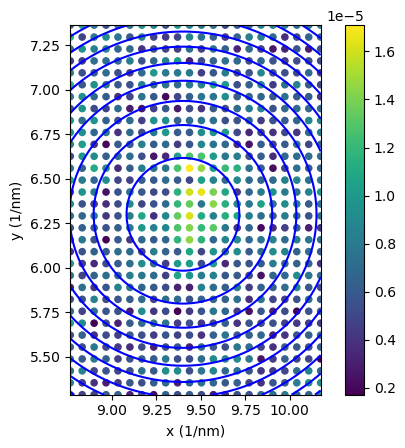

In [ ]:
# Testing Window by Drawing It
fig3, ax3 = plt.subplots()

#sca3 = ax3.scatter(df['X'], df['Y'], c=df['Z'], s=1)
#ax3.scatter(df_sub['X'], df_sub['Y'], c=np.zeros_like(df_sub['Z']) + np.max(df['Z']), s=1)

# plot fit
fitx = np.linspace(np.min(df_sub['X']), np.max(df_sub['X']), 100)
fity = np.linspace(np.min(df_sub['Y']), np.max(df_sub['Y']), 100)

fitxx, fityy = np.meshgrid(fitx, fity)
fitz = twoD_Gaussian((fitxx, fityy), *popt)

sc3 = ax3.scatter(df_sub['X'], df_sub['Y'], c=df_sub['Z'], s=20)
ax3.contour(fitx, fity, fitz.reshape(100, 100), 10, colors='b')

#ax3.imshow(fitz.reshape(100, 100))
cb3 = plt.colorbar(sc3, ax=ax3)
#cb3.set_label('Z (a.u)')
ax3.set_xlim([fitx[0], fitx[-1]])
ax3.set_ylim([fity[0], fity[-1]])
ax3.set_xlabel("x (1/nm)")
ax3.set_ylabel("y (1/nm)")
ax3.set_aspect('equal')

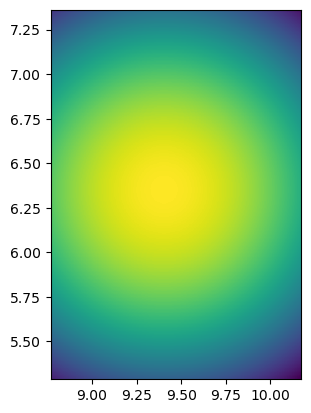

In [ ]:
fig4, ax4 = plt.subplots()

ax4.imshow(fitz.reshape(100, 100), extent=[fitx.min(), fitx.max(), fity.min(), fity.max()])